---
title: Querying Human Reference Epigenome
description: We first collected the TSS of all human genes where we have expression data for the orthologous rat gene. We used Laura's tools to query CAGE tracks from genome-wide Enformer predictions on the reference genome.
date: 8/17/2023
author: Sabrina Mi
---

## Setup

In [5]:
import h5py
import pandas as pd
import numpy as np
from kipoiseq import Interval
import matplotlib.pyplot as plt
import seaborn as sns


enfref_dir = "/grand/TFXcan/imlab/users/lvairus/reftile_project/enformer-reference-epigenome"

def query_epigenome(chr_num, center_bp, num_bins=3, tracks=-1):
    """
    Parameters:
        path_to_enfref (str): path to the directory containing the concatenated reference enformer files
        chr_num (int/string): chromosome number
        center_bp (int): center base pair position (1-indexed)
        num_bins (int): number of bins to extract centered around center_bp (default: 896) 
            note: if the number of bins is even, the center bin will be in the second half of the array
        tracks (int list): list of tracks to extract (default: all 5313 tracks)

    Returns:
        epigen (np.array): enformer predictions centered at center_bp of shape (num_bins, len(tracks))
    """

    # from position choose center bin
    center_ind = center_bp - 1
    center_bin = center_ind // 128
    
    half_bins = num_bins // 2
    start_bin = center_bin - half_bins
    end_bin = center_bin + half_bins
    if num_bins % 2 != 0: # if num_bins is odd
        end_bin += 1

    with h5py.File(f"{enfref_dir}/chr{chr_num}_cat.h5", "r") as f:
        # get tracks if list provided
        if tracks == -1:
            epigen = f[f'chr{chr_num}'][start_bin:end_bin, :] 
        else:
            epigen = f[f'chr{chr_num}'][start_bin:end_bin, tracks] 

    return epigen

## Collect TSS for all human genes

We collected all protein-coding genes and their cannonical TSS using the biomaRt package.


In [10]:

hg38_annot = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.protein_coding_TSS.txt", header=0, sep="\t", index_col='ensembl_gene_id')
print(hg38_annot.shape[0], "genes with TSS annotation")
hg38_annot.head()

19688 genes with TSS annotation


,external_gene_name,chromosome_name,transcription_start_site
ensembl_gene_id,,,
ENSG00000142611,PRDM16,1,3069203
ENSG00000157911,PEX10,1,2412564
ENSG00000142655,PEX14,1,10474950
ENSG00000149527,PLCH2,1,2476289
ENSG00000171621,SPSB1,1,9292894


We computed the predicted human reference epigenome by running Enformer on all intervals spanning the genome and concatenting the results. Now we extract the CAGE:Brain track at the bins where each gene's TSS fall in order to quantify relative expression across genes.  

## Query reference epigenome at TSS

I found that querying the epigenome at certain positions returned NA, so I investigated those positions further by querying a larger window and plotting the CAGE track 4980.

In [3]:
CAGE_predictions = []
for gene in hg38_annot.index:
    chr = hg38_annot.loc[gene]['chromosome_name']
    tss = hg38_annot.loc[gene]['transcription_start_site']
    bin = query_epigenome(chr,tss, num_bins = 1, tracks=[4980])
    if np.isnan(bin):
        print("Invalid query:", gene, "at", f"{chr}:{tss}")
        break
    CAGE_predictions.append(bin)


Invalid query: ENSG00000173451 at 12:71664301


In [4]:
with h5py.File(f"{enfref_dir}/chr12_cat.h5", "r") as f:
    print("matrix shape:", f['chr12'].shape)
    center = 71664301//128
    print("ENSG00000173451 TTS at bin", center)
    epigen = f['chr12'][center-448:center+448, 4980]
    print("Number of NA along track:", sum(np.isnan(epigen)))
    


matrix shape: (1041214, 5313)
ENSG00000173451 TTS at bin 559877
Number of NA along track: 448


We adapted a function from the Enformer usage notebook to plot a single track.

In [6]:
def plot_track(title, y, interval, height=1.5):
  fig, ax = plt.subplots(figsize=(20, height))
  ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
  ax.set_title(title)
  sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

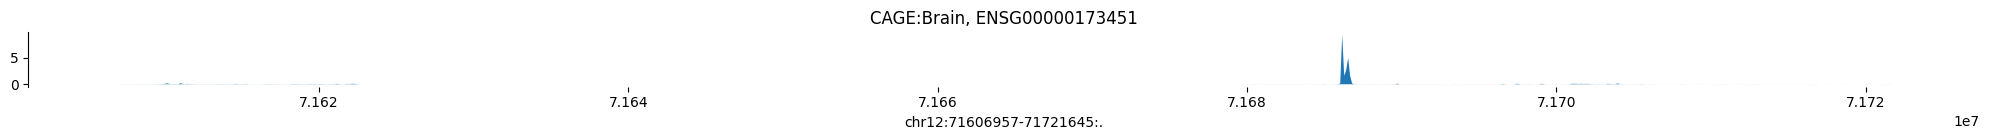

In [8]:
tss = Interval('chr12', 71664301, 71664301)
plot_track('CAGE:Brain, ENSG00000173451', epigen, tss.resize(114688))